In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import os
import sys
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
import time
from collections import Counter
tqdm.pandas(tqdm_notebook)
import lightgbm as lgb
import gc
import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
pd.set_option('display.float_format', '{:.5f}'.format)
SEED = 51
np.random.seed(SEED)
%matplotlib inline

In [2]:
train = dd.read_csv('../input/train_final.csv')
test = dd.read_csv('../input/test_final.csv')
train = train.compute()
test = test.compute()
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [3]:
print(train.shape,test.shape)

(201917, 444) (123623, 443)


In [4]:
corr_ = ['new_month_diff_mean', 'h_month_diff_mean', 'a_month_diff_mean', 'month_diff_mean', 'hist_month_diff_mean', 'h_purchase_amount_max', 'h_num_most_common_category_3', 'card_id_total', 'h_purchase_amount_std', 'h_purchase_amount_mean', 'h_purchase_amount_sum']

In [5]:
train.drop(corr_,axis=1,inplace=True)
test.drop(corr_,axis=1,inplace=True)

In [6]:
#k = train.corr()

In [7]:
y = train['target']
del train['target']

In [8]:
train.head()

,card_id,feature_1,feature_2,feature_3,first_active_month,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_month_nunique,hist_month_mean,hist_month_min,hist_month_max,hist_hour_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_weekofyear_nunique,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_weekday_mean,hist_day_nunique,hist_day_mean,hist_day_min,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_var,hist_month_diff_skew,hist_authorized_flag_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_mean,hist_category_3_mean,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_Christmas_Day_2017_mean,hist_Mothers_Day_2017_mean,hist_fathers_day_2017_mean,hist_Children_day_2017_mean,hist_Valentine_Day_2017_mean,hist_Black_Friday_2017_mean,hist_Mothers_Day_2018_mean,hist_duration_mean,hist_duration_min,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,new_subsector_id_nunique,new_merchant_id_nunique,new_merchant_category_id_nunique,new_month_mean,new_month_min,new_month_max,new_hour_nunique,new_hour_mean,new_hour_min,new_hour_max,new_weekofyear_nunique,new_weekofyear_mean,new_weekofyear_min,new_weekofyear_max,new_weekday_mean,new_weekday_min,new_weekday_max,new_day_nunique,new_day_mean,new_day_min,new_day_max,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_var,new_purchase_amount_skew,new_installments_sum,new_installments_max,new_installments_mean,new_installments_var,new_installments_skew,new_month_lag_max,new_month_lag_min,new_month_lag_mean,new_month_lag_var,new_month_lag_skew,new_month_diff_var,new_month_diff_skew,new_weekend_mean,new_category_1_mean,new_category_2_mean,new_category_3_mean,new_price_mean,new_price_max,new_price_min,new_price_var,new_Christmas_Day_2017_mean,new_Children_day_2017_mean,new_Black_Friday_2017_mean,new_Mothers_Day_2018_mean,new_duration_mean,new_duration_min,new_duration_max,new_duration_var,new_duration_skew,new_amount_month_ratio_mean,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_var,new_amount_month_ratio_skew,new_category_2_mean_mean,new_category_3_mean_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,hist_first_buy,hist_last_buy,new_first_buy,new_last_buy,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,active_year,active_month,h_af_sum,h_af_min,h_af_max,h_af_std,h_af_mean,h_af_median,h_how_many_city_visited,h_most_visited_city,h_num_most_visited_city,h_second_most_visited_city,h_num_second_most_visited_city,h_third_most_visited_city,h_num_third_most_visited_city,h_most_common_category_1,h_num_most_common_category_1,h_seco

In [9]:
"""corr_list = []
for i in range(len(k)):
    for j in range(len(k)):
        if (k.iloc[i,j] >= 0.99) & (i != j):
            corr_list.append([k.index[i],k.columns[j]])"""

'corr_list = []\nfor i in range(len(k)):\n    for j in range(len(k)):\n        if (k.iloc[i,j] >= 0.99) & (i != j):\n            corr_list.append([k.index[i],k.columns[j]])'

In [10]:
"""used_ = []
for i in corr_list:
    for j in i:
        used_.append(j)"""

'used_ = []\nfor i in corr_list:\n    for j in i:\n        used_.append(j)'

In [11]:
#len(set(used_))

In [12]:
#list(pd.Series(used_).value_counts().head(11).index)

In [13]:
stratified = False

if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=SEED)
else:
    folds = KFold(n_splits= 5, shuffle=True, random_state=SEED)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

In [14]:
temp = train.dtypes.reset_index(drop=False)
temp.columns = ['column','type']
for i in [x for x in list(temp[temp['type'] == 'object']['column']) if x not in ['card_id', 'first_active_month']]:
    le = preprocessing.LabelEncoder()
    le.fit(list(train[i].values) + list(test[i].values ) )
    train[i] = le.transform( list(train[i].values) )
    test[i] = le.transform( list(test[i].values) )

In [15]:
feats = [c for c in train.columns if c not in ['card_id', 'first_active_month'] ]

In [16]:
# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [17]:
%%time
# k-fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats],y)):
    train_x, train_y = train[feats].iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = train[feats].iloc[valid_idx], y.iloc[valid_idx]

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                           label=valid_y,
                           free_raw_data=False)

    # params optimized by optuna
    params = {'num_leaves': '100',
             'min_data_in_leaf': '125',
             'objective': 'regression',
             'max_depth': '8',
             'learning_rate': '0.004',
             'boosting': 'gbdt',
             'feature_fraction': '0.6',
             'bagging_freq': 1,
             'bagging_fraction': '0.9',
             'metric': 'rmse',
             'lambda_l1': '0.25',
             'random_state': 51,
             'verbosity': -1}

    reg = lgb.train(
                    params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    valid_names=['train', 'test'],
                    num_boost_round=10000,
                    early_stopping_rounds= 200,
                    verbose_eval=200
                    )

    oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
    sub_preds += reg.predict(test[feats], num_iteration=reg.best_iteration) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #fold_rmse = rmse(valid_y, oof_preds[valid_idx])
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
    del reg, train_x, train_y, valid_x, valid_y
    gc.collect()
print("Average RMSE = {}".format(rmse(y,oof_preds)))

Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 3.64096	test's rmse: 3.80515
[400]	train's rmse: 3.55839	test's rmse: 3.75876
[600]	train's rmse: 3.50835	test's rmse: 3.74023
[800]	train's rmse: 3.4719	test's rmse: 3.73156
[1000]	train's rmse: 3.44341	test's rmse: 3.72733
[1200]	train's rmse: 3.42077	test's rmse: 3.72505
[1400]	train's rmse: 3.4008	test's rmse: 3.72336
[1600]	train's rmse: 3.3818	test's rmse: 3.72236
[1800]	train's rmse: 3.3638	test's rmse: 3.72164
[2000]	train's rmse: 3.34701	test's rmse: 3.72095
[2200]	train's rmse: 3.33044	test's rmse: 3.7207
Early stopping, best iteration is:
[2179]	train's rmse: 3.33223	test's rmse: 3.7206
Fold  1 RMSE : 3.720600
Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 3.67851	test's rmse: 3.64869
[400]	train's rmse: 3.59511	test's rmse: 3.607
[600]	train's rmse: 3.54569	test's rmse: 3.59313
[800]	train's rmse: 3.50909	test's rmse: 3.58619
[1000]	train's rmse: 3.48129	te

In [19]:
#Train
reg_preds_train = pd.concat([train['card_id'],pd.Series(oof_preds)],axis=1)
reg_preds_train.columns = ['card_id','reg_prob']
#Test
reg_preds_test = pd.concat([test['card_id'],pd.Series(sub_preds)],axis=1)
reg_preds_test.columns = ['card_id','reg_prob']
#Writing as csv's
reg_preds_train.to_csv('train_reg_preds.csv',index=False)
reg_preds_test.to_csv('test_reg_preds.csv',index=False)

# BINARY CLASSIFCATION

In [20]:
y_binary = y.apply(lambda x: 1 if x < -32 else 0)

In [21]:
stratified = False

if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=SEED)
else:
    folds = KFold(n_splits= 5, shuffle=True, random_state=SEED)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

In [22]:
%%time
# k-fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats],y_binary)):
    train_x, train_y = train[feats].iloc[train_idx], y_binary.iloc[train_idx]
    valid_x, valid_y = train[feats].iloc[valid_idx], y_binary.iloc[valid_idx]

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                           label=valid_y,
                           free_raw_data=False)

    # params optimized by optuna
    params = {'num_leaves': '100',
             'min_data_in_leaf': '125',
             'objective': 'binary',
             'max_depth': '8',
             'learning_rate': '0.004',
             'boosting': 'gbdt',
             'feature_fraction': '0.6',
             'bagging_freq': 1,
             'bagging_fraction': '0.9',
             'metric': 'auc',
             'lambda_l1': '0.25',
             'random_state': 51,
             'verbosity': -1}

    reg = lgb.train(
                    params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    valid_names=['train', 'test'],
                    num_boost_round=10000,
                    early_stopping_rounds= 200,
                    verbose_eval=200
                    )

    oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
    sub_preds += reg.predict(test[feats], num_iteration=reg.best_iteration) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_binary, oof_preds) ))
    del reg, train_x, train_y, valid_x, valid_y
    gc.collect()
print("Average AUC = {}".format( roc_auc_score(y_binary, oof_preds) ) )

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.965065	test's auc: 0.906991
[400]	train's auc: 0.977987	test's auc: 0.911119
[600]	train's auc: 0.98604	test's auc: 0.912318
[800]	train's auc: 0.990108	test's auc: 0.913085
[1000]	train's auc: 0.992982	test's auc: 0.913257
[1200]	train's auc: 0.995189	test's auc: 0.9132
Early stopping, best iteration is:
[1052]	train's auc: 0.993613	test's auc: 0.913367
Fold  1 AUC : 0.524409
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.961206	test's auc: 0.902628
[400]	train's auc: 0.974832	test's auc: 0.904542
[600]	train's auc: 0.984062	test's auc: 0.906907
[800]	train's auc: 0.98885	test's auc: 0.907506
[1000]	train's auc: 0.991719	test's auc: 0.90764
[1200]	train's auc: 0.993982	test's auc: 0.90809
[1400]	train's auc: 0.995881	test's auc: 0.908183
[1600]	train's auc: 0.997143	test's auc: 0.908391
Early stopping, best iteration is:
[1577]	train's auc: 0.996987	test's auc: 0.90

In [23]:
print("Average AUC = {}".format( roc_auc_score(y_binary, oof_preds) ) )

Average AUC = 0.9036075644528246


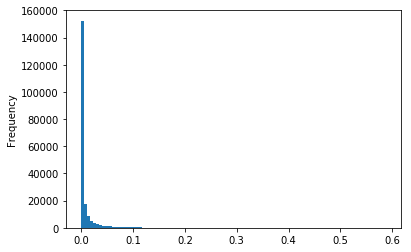

In [24]:
pd.Series(oof_preds).plot(kind='hist',bins=100)
plt.show()

In [25]:
#Train
binary_preds_train = pd.concat([train['card_id'],pd.Series(oof_preds)],axis=1)
binary_preds_train.columns = ['card_id','binary_prob']
#Test
binary_preds_test = pd.concat([test['card_id'],pd.Series(sub_preds)],axis=1)
binary_preds_test.columns = ['card_id','binary_prob']
#Writing as csv's
binary_preds_train.to_csv('train_binary_preds.csv',index=False)
binary_preds_test.to_csv('test_binary_preds.csv',index=False)

# Regression

In [28]:
train_reg = train[y > -32]
train_reg_ = train[y < -32]
print(train_reg.shape,train_reg_.shape)

(199710, 432) (2207, 432)


In [29]:
y_reg = y[ y > -32 ]
y_reg_ = y[ y < -32 ]
print(y_reg.shape,y_reg_.shape)

(199710,) (2207,)


In [33]:
stratified = False

if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=SEED)
else:
    folds = KFold(n_splits= 5, shuffle=True, random_state=SEED)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_reg.shape[0])
outlier_preds = np.zeros(train_reg_.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

In [34]:
%%time
# k-fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_reg[feats],y_reg)):
    train_x, train_y = train_reg[feats].iloc[train_idx], y_reg.iloc[train_idx]
    valid_x, valid_y = train_reg[feats].iloc[valid_idx], y_reg.iloc[valid_idx]

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                           label=valid_y,
                           free_raw_data=False)

    # params optimized by optuna
    params = {'num_leaves': '100',
             'min_data_in_leaf': '125',
             'objective': 'regression',
             'max_depth': '8',
             'learning_rate': '0.004',
             'boosting': 'gbdt',
             'feature_fraction': '0.6',
             'bagging_freq': 1,
             'bagging_fraction': '0.9',
             'metric': 'rmse',
             'lambda_l1': '0.25',
             'random_state': 51,
             'verbosity': -1}

    reg = lgb.train(
                    params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    valid_names=['train', 'test'],
                    num_boost_round=10000,
                    early_stopping_rounds= 200,
                    verbose_eval=200
                    )

    oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
    sub_preds += reg.predict(test[feats], num_iteration=reg.best_iteration) / folds.n_splits
    outlier_preds += reg.predict(train_reg_[feats], num_iteration=reg.best_iteration) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
    del reg, train_x, train_y, valid_x, valid_y
    gc.collect()
print("Average RMSE = {}".format(rmse(y_reg,oof_preds)))

Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 1.59948	test's rmse: 1.60675
[400]	train's rmse: 1.55678	test's rmse: 1.57404
[600]	train's rmse: 1.53454	test's rmse: 1.56153
[800]	train's rmse: 1.51916	test's rmse: 1.55551
[1000]	train's rmse: 1.507	test's rmse: 1.55226
[1200]	train's rmse: 1.49735	test's rmse: 1.55035
[1400]	train's rmse: 1.48928	test's rmse: 1.54917
[1600]	train's rmse: 1.48221	test's rmse: 1.54828
[1800]	train's rmse: 1.47601	test's rmse: 1.5477
[2000]	train's rmse: 1.47028	test's rmse: 1.54726
[2200]	train's rmse: 1.46477	test's rmse: 1.54696
[2400]	train's rmse: 1.45977	test's rmse: 1.54672
[2600]	train's rmse: 1.45453	test's rmse: 1.54646
[2800]	train's rmse: 1.44928	test's rmse: 1.54626
[3000]	train's rmse: 1.44397	test's rmse: 1.54608
[3200]	train's rmse: 1.43873	test's rmse: 1.54596
[3400]	train's rmse: 1.43397	test's rmse: 1.54585
[3600]	train's rmse: 1.42881	test's rmse: 1.54583
[3800]	train's rmse: 1.424	test's rmse: 1.54

In [35]:
print("Average RMSE = {}".format(rmse(y_reg,oof_preds)))

Average RMSE = 1.5514257602072274


In [41]:
oof_preds.shape,outlier_preds.shape,sub_preds.shape

((199710,), (2207,), (123623,))

In [40]:
outlierless_train = pd.concat([train_reg['card_id'].reset_index(drop=True),pd.Series(oof_preds)],axis=1)
outlierless_train_ = pd.concat([train_reg_['card_id'].reset_index(drop=True),pd.Series(outlier_preds)],axis=1)
outlierless_test = pd.concat([test['card_id'],pd.Series(sub_preds)],axis=1)
outlierless_train.columns = ['card_id','without_outlier']
outlierless_train_.columns = ['card_id','without_outlier']
outlierless_test.columns = ['card_id','without_outlier']
print(outlierless_train.shape,outlierless_train_.shape,outlierless_test.shape)

(199710, 2) (2207, 2) (123623, 2)


In [42]:
outlierless_train = pd.concat([outlierless_train,outlierless_train_],axis=0)
outlierless_train = outlierless_train.reset_index(drop=True)

In [44]:
outlierless_train['card_id'].nunique()

201917

In [48]:
outlierless_train.to_csv('train_outlierless.csv',index=False)
outlierless_test.to_csv('test_outlierless.csv',index=False)

In [ ]:
#test['target'] = sub_preds

In [ ]:
#submission_file_name = '../my_submissions/deneme3'
#test[['card_id', 'target']].to_csv(submission_file_name, index=False)